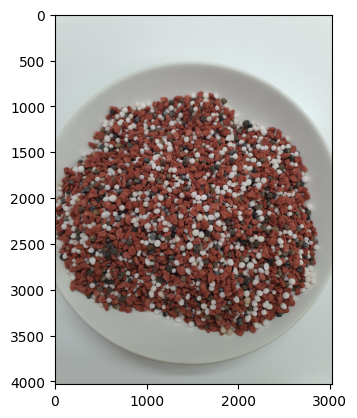

In [1]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt

# === Load the image ===
folder_path_1 = "D:/2D/pictures/14-7-35"
folder_path_2 = "D:/2D/pictures/15-7-18"
folder_path_3 = "D:/2D/pictures/15-15-15"
folder_path_4 = "D:/2D/pictures/18-4-5"
images_path_1 = [os.path.join(folder_path_1, f) for f in os.listdir(folder_path_1) if f.endswith('.jpg')]
images_path_2 = [os.path.join(folder_path_2, f) for f in os.listdir(folder_path_2) if f.endswith('.jpg')]
images_path_3 = [os.path.join(folder_path_3, f) for f in os.listdir(folder_path_3) if f.endswith('.jpg')]
images_path_4 = [os.path.join(folder_path_4, f) for f in os.listdir(folder_path_4) if f.endswith('.jpg')]

# Optional: visualize the image (for debugging)
image_bgr = cv2.imread(images_path_1[1])  # Load the first image from the first folder
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()


Image dimensions: 4032x3024


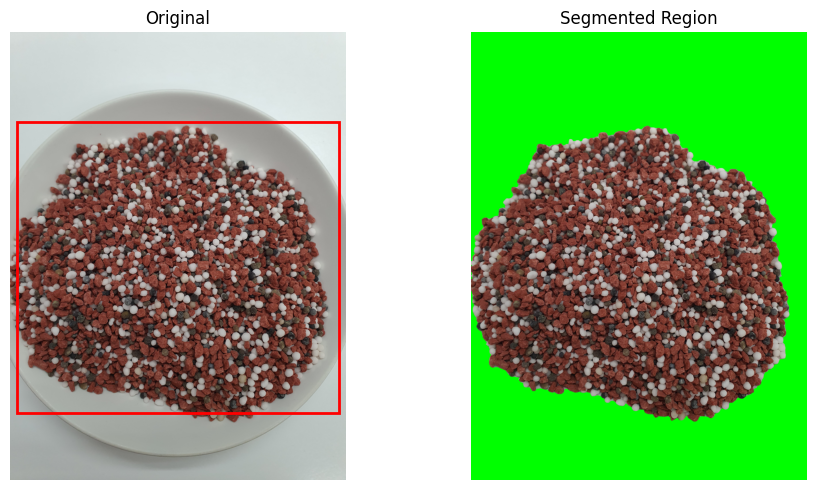

In [2]:
import torch
from segment_anything import sam_model_registry, SamPredictor

# === Load the SAM model ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"  # Path to your checkpoint file
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# === Load and prepare the image ===
image_bgr = cv2.imread(images_path_1[1])  # Change to your image path
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

# === Define a bounding box ===
# Format: [x0, y0, x1, y1] (top-left to bottom-right)
H, W = image_rgb.shape[:2]
print(f"Image dimensions: {H}x{W}")
min_h =  int(H * 0.2)  # Minimum height for the box
max_h = int(H * 0.85)   # Maximum height for the box
min_w = int(W * 0.02)   # Minimum width for the box
max_w = int(W * 0.98)   # Maximum width for the box
input_box = np.array([min_w, min_h, max_w, max_h])  # ← Change as needed

# === Segment using the box ===
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=False  # Only return the most confident mask
)

# === Visualize ===
mask = masks[0]

# Overlay the mask
masked_image = image_rgb.copy()
masked_image[~mask] = [0, 255, 0]  # Set everything else to black

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.gca().add_patch(plt.Rectangle(
    (input_box[0], input_box[1]),
    input_box[2] - input_box[0],
    input_box[3] - input_box[1],
    edgecolor='red',
    linewidth=2,
    facecolor='none'
))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Segmented Region")
plt.axis('off')

plt.tight_layout()
plt.show()


Running KMeans...


c:\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cw

Running SAM for grain masks...


Clusters: 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]


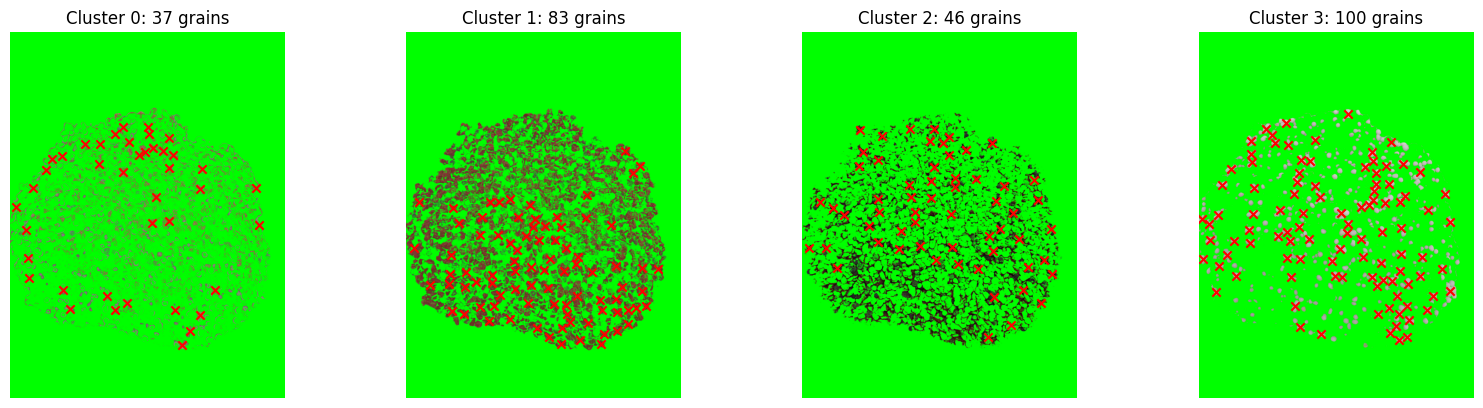


 Grain Count Summary:
  Cluster 0: 37 grains
  Cluster 1: 83 grains
  Cluster 2: 46 grains
  Cluster 3: 100 grains
  Total grains: 266
 Creating colored overlay...


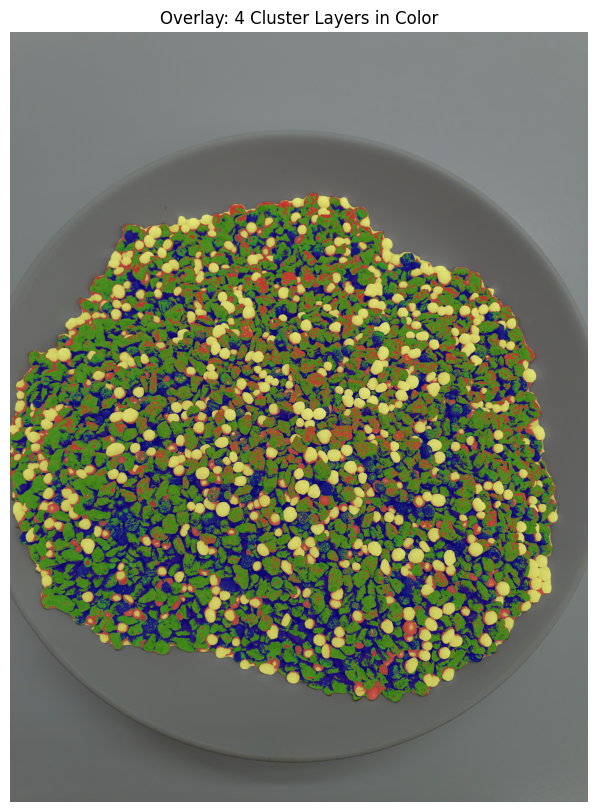

In [3]:
from sklearn.cluster import KMeans
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm

# === Config ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
BEAD_MASKS = 4

# === Initialize SAM ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

# === Preprocess image ===
H, W, _ = masked_image.shape
pixels = masked_image.reshape(-1, 3)
non_green = np.any(pixels != [0, 255, 0], axis=1)
valid_indices = np.where(non_green)[0]
pixels_non_green = pixels[non_green]

# === Preprocess: Mask non-green pixels ===
H, W, _ = masked_image.shape
pixels = masked_image.reshape(-1, 3)
non_green = np.any(pixels != [0, 255, 0], axis=1)
valid_indices = np.where(non_green)[0]
pixels_non_green = pixels[non_green]

def apply_clahe_rgb(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    enhanced_rgb = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced_rgb

# === KMeans clustering ===
print("Running KMeans...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixels_non_green)

# === Generate color masks ===
all_masks = []
for i in range(BEAD_MASKS):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixels = valid_indices[labels == i]
    mask_flat[cluster_pixels] = True
    all_masks.append(mask_flat.reshape(H, W))

# === Function: Detect grain centers using contours ===
def get_centers(mask, min_area=3000, min_dist=70):
    centers = []
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < 150000:  # optional upper bound
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                if all(np.hypot(cx - x, cy - y) > min_dist for x, y in centers):
                    centers.append((cx, cy))
    return centers

# === Count grains using SAM ===
print("Running SAM for grain masks...")
all_counts, all_centers = [], []
predictor.set_image(image_rgb)

for i, mask in enumerate(tqdm(all_masks, desc="Clusters")):
    centers = get_centers(mask)
    count = 0
    for x, y in centers:
        try:
            # Predict masks from multiple points around center
            offsets = [(0, 0), (-5, 0), (5, 0), (0, -5), (0, 5)]
            points = np.array([[x+dx, y+dy] for dx, dy in offsets])
            labels = np.ones(len(points))
            masks, scores, _ = predictor.predict(
                point_coords=points,
                point_labels=labels,
                multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]

            if np.sum(best_mask) > 50 and np.sum(mask & best_mask) / np.sum(best_mask) > 0.15:
                count += 1
        except:
            continue
    all_counts.append(count)
    all_centers.append(centers)

# === Visualization ===
plt.figure(figsize=(16, 8))
for i, (mask, centers) in enumerate(zip(all_masks, all_centers)):
    cluster_img = np.full_like(image_rgb, [0, 255, 0])  # green bg
    cluster_img[mask] = image_rgb[mask]
    plt.subplot(2, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    if centers:
        cx, cy = zip(*centers)
        plt.scatter(cx, cy, c='red', marker='x')
    plt.title(f"Cluster {i}: {all_counts[i]} grains")
    plt.axis('off')
plt.tight_layout()
plt.show()

# === Summary ===
print("\n Grain Count Summary:")
for i, c in enumerate(all_counts):
    print(f"  Cluster {i}: {c} grains")
print(f"  Total grains: {sum(all_counts)}")

# === Colored Overlay of All Clusters ===
print(" Creating colored overlay...")

# Define unique overlay colors for 4 clusters
overlay_colors = [
    [255, 0, 0],     # Red
    [0, 255, 0],     # Green
    [0, 0, 255],     # Blue
    [255, 255, 0],   # Yellow
]

overlay_image = np.zeros_like(image_rgb, dtype=np.uint8)

for i, mask in enumerate(all_masks):
    color = np.array(overlay_colors[i % len(overlay_colors)], dtype=np.uint8)
    overlay_image[mask] = color

# Blend overlay with original image
blended = cv2.addWeighted(image_rgb, 0.6, overlay_image, 0.4, 0)

# Plot result
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title("Overlay: 4 Cluster Layers in Color")
plt.axis("off")
plt.show()


 Enhancing image...


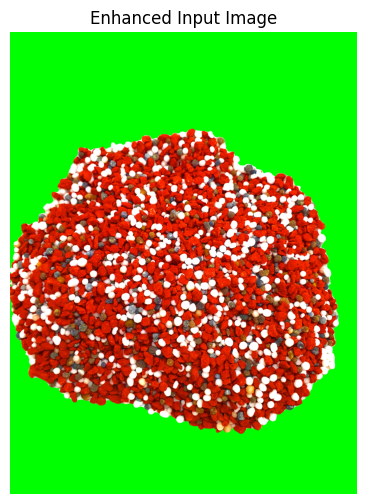

 Flattening and filtering pixels...
 Running KMeans with 4 clusters...
 Creating masks for each cluster...


Clusters:  25%|██▌       | 1/4 [00:02<00:07,  2.34s/it]

 Cluster 0: 2629781 points


Clusters:  50%|█████     | 2/4 [00:03<00:03,  1.63s/it]

 Cluster 1: 1089888 points


Clusters:  75%|███████▌  | 3/4 [00:04<00:01,  1.13s/it]

 Cluster 2: 604696 points


Clusters: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

 Cluster 3: 1484369 points
 Displaying color-separated clusters...


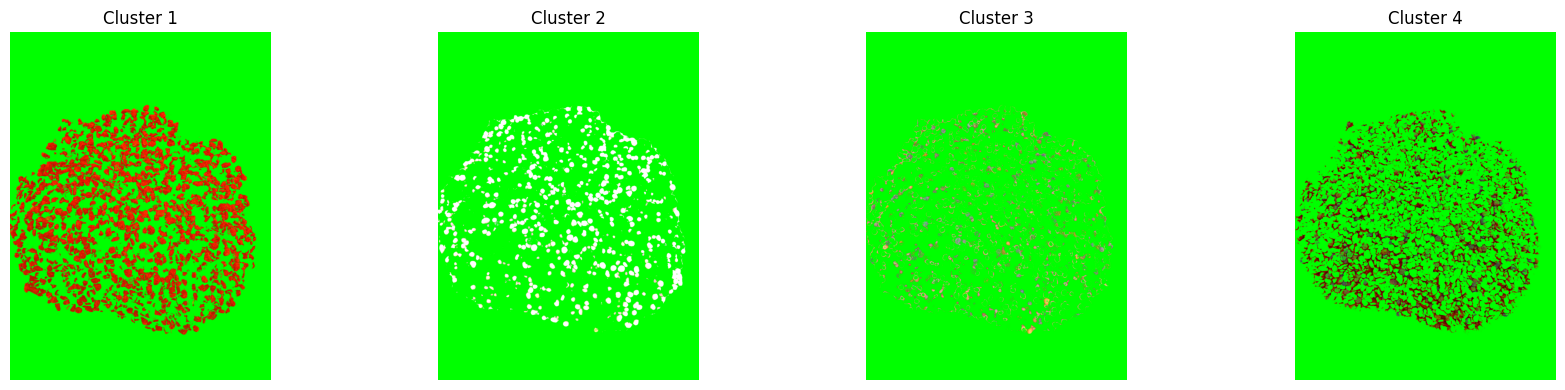

In [4]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm  # Progress bar

# === CONFIG ===
BEAD_MASKS = 4              # Number of color clusters to find
CONTRAST_FACTOR = 1.5       # >1 = more contrast
SATURATION_FACTOR = 3       # >1 = more vivid
BRIGHTNESS_OFFSET = 20      # Positive = brighter

# === Enhance Function ===
def enhance_image(image, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    img = np.clip(image.astype(np.float32), 0, 255)
    img = np.clip(img + brightness, 0, 255)
    img = np.clip(contrast * img, 0, 255)
    img_uint8 = img.astype(np.uint8)

    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation, 0, 255)
    hsv = np.clip(hsv, 0, 255)
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return np.clip(enhanced, 0, 255).astype(np.uint8)

# === Grouping function ===
def get_all_grouped_points(label, labels, valid_indices, W):
    point_coords = []
    group_indices = np.where(labels == label)[0]
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])
    return np.array(point_coords)

# === Enhance the image (masked_image must already exist) ===
print(" Enhancing image...")
enhanced_image = enhance_image(masked_image)

# === Show enhanced image ===
plt.figure(figsize=(6, 6))
plt.imshow(enhanced_image)
plt.title("Enhanced Input Image")
plt.axis('off')
plt.show()

# === Prepare for clustering ===
print(" Flattening and filtering pixels...")
H, W, _ = enhanced_image.shape
pixels = enhanced_image.reshape(-1, 3)

non_green_indices = np.any(pixels != [0, 255, 0], axis=1)
pixels_non_green = pixels[non_green_indices]
valid_indices = np.where(non_green_indices)[0]

# === KMeans clustering ===
print(f" Running KMeans with {BEAD_MASKS} clusters...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_green)import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
import torch
from segment_anything import sam_model_registry, SamPredictor

# === CONFIG ===
zip_path = "pictures/14-7-35.zip"  # <-- keep using original structure
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
BEAD_MASKS = 4  # number of clusters

# === Load images from ZIP ===
def load_images_from_zip(zip_path):
    image_list = []
    with zipfile.ZipFile(zip_path, 'r') as archive:
        for file in archive.namelist():
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                data = archive.read(file)
                image_array = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR)
                image_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
                image_list.append((file, image_rgb))
    return image_list

# === Grain center detector using contours ===
def get_centers(mask, min_area=3000, min_dist=70):
    centers = []
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < 150000:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                if all(np.hypot(cx - x, cy - y) > min_dist for x, y in centers):
                    centers.append((cx, cy))
    return centers

# === Main pipeline ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

image_list = load_images_from_zip(zip_path)
print(f"📦 Loaded {len(image_list)} images from {zip_path}")

for idx, (filename, image_rgb) in enumerate(image_list):
    print(f"\n🖼 Processing: {filename} ({image_rgb.shape})")

    # Mask out green background
    H, W, _ = image_rgb.shape
    masked_image = image_rgb.copy()
    pixels = masked_image.reshape(-1, 3)
    non_green = np.any(pixels != [0, 255, 0], axis=1)
    valid_indices = np.where(non_green)[0]
    pixels_non_green = pixels[non_green]

    # KMeans clustering
    kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels_non_green)

    all_masks = []
    for i in range(BEAD_MASKS):
        mask_flat = np.zeros(H * W, dtype=bool)
        cluster_pixels = valid_indices[labels == i]
        mask_flat[cluster_pixels] = True
        all_masks.append(mask_flat.reshape(H, W))

    # Predict masks using SAM
    predictor.set_image(image_rgb)
    all_counts = []
    all_centers = []

    for i, mask in enumerate(tqdm(all_masks, desc=f"Clustering ({filename})")):
        centers = get_centers(mask)
        count = 0
        for x, y in centers:
            try:
                offsets = [(0, 0), (-5, 0), (5, 0), (0, -5), (0, 5)]
                points = np.array([[x + dx, y + dy] for dx, dy in offsets])
                labels = np.ones(len(points))
                masks, scores, _ = predictor.predict(
                    point_coords=points,
                    point_labels=labels,
                    multimask_output=True
                )
                best_mask = masks[np.argmax(scores)]
                if np.sum(best_mask) > 50 and np.sum(mask & best_mask) / np.sum(best_mask) > 0.15:
                    count += 1
            except:
                continue
        all_counts.append(count)
        all_centers.append(centers)

    # Show result
    plt.figure(figsize=(16, 8))
    for i, (mask, centers) in enumerate(zip(all_masks, all_centers)):
        cluster_img = np.full_like(image_rgb, [0, 255, 0])
        cluster_img[mask] = image_rgb[mask]
        plt.subplot(2, BEAD_MASKS, i + 1)
        plt.imshow(cluster_img)
        if centers:
            cx, cy = zip(*centers)
            plt.scatter(cx, cy, c='red', marker='x')
        plt.title(f"Cluster {i}: {all_counts[i]} grains")
        plt.axis('off')
    plt.suptitle(f"Result for {filename}")
    plt.tight_layout()
    plt.show()

    # Summary
    print("📊 Grain Count:")
    for i, c in enumerate(all_counts):
        print(f"  Cluster {i}: {c}")
    print(f"  Total: {sum(all_counts)} grains")


# === Cluster masks ===
all_masks = []
all_point_coords = []

print(" Creating masks for each cluster...")
for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixel_indices = valid_indices[labels == cluster_label]
    mask_flat[cluster_pixel_indices] = True
    mask_2d = mask_flat.reshape(H, W)

    point_coords = get_all_grouped_points(cluster_label, labels, valid_indices, W)

    all_masks.append(mask_2d)
    all_point_coords.append(point_coords)

    print(f" Cluster {cluster_label}: {len(point_coords)} points")

# === Visualize result ===
print(" Displaying color-separated clusters...")
plt.figure(figsize=(18, 4))
for i in range(BEAD_MASKS):
    cluster_img = np.full_like(enhanced_image, fill_value=[0, 255, 0])  # Green background
    cluster_img[all_masks[i]] = enhanced_image[all_masks[i]]  # Overlay original color

    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    plt.title(f"Cluster {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()
